<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/Projects/blob/main/X-ray%20Implant%20Identification/Self_Supervised_Contrastive_Learning_with_SimCLR_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Contrastive Learning with SimCLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pathlib
import random
import matplotlib.image as mpimg

In [ ]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# DATASET_PATH = "/content/drive/MyDrive/Implant_data_Final_aug"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Global seed set to 42


Device: cpu
Number of workers: 2


In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [ ]:
def to_grey(img):
  img=np.array(img)

  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

In [ ]:
path_train = '/content/drive/MyDrive/Latest_data_implant/train/'
path_test = '/content/drive/MyDrive/Latest_data_implant/test/'
dimensions = (300, 300)
new_path_train= '/content/drive/MyDrive/new_data/train/'
new_path_test= '/content/drive/MyDrive/new_data/test/'

In [ ]:
# convert any images with four channels into three channels


for clas in os.listdir(path_train):
  pathlib.Path(new_path_train + clas).mkdir(parents=True, exist_ok=True) 
  for i in os.listdir(path_train+clas):
    img = mpimg.imread(path_train+clas+'/'+i,0)
    if len(img.shape)>2:
      if img.shape[2]==4:
        img = to_grey(img)
        min_val,max_val=img.min(),img.max()
        img = 255.0*(img - min_val)/(max_val - min_val)
        img = img.astype(np.uint8)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        new_image = cv2.resize(gray_image, dimensions, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(new_path_train+clas+'/'+i+'.jpg',new_image)
      else:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        new_image = cv2.resize(gray_image, dimensions, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(new_path_train+clas+'/'+i+'.jpg',new_image)
    else:
      new_image = cv2.resize(img, dimensions, interpolation=cv2.INTER_LINEAR)
      cv2.imwrite(new_path_train+clas+'/'+i+'.jpg',new_image)


for clas in os.listdir(path_test):
  pathlib.Path(new_path_test + clas).mkdir(parents=True, exist_ok=True) 
  for i in os.listdir(path_test+clas):
    img = mpimg.imread(path_test+clas+'/'+i)
    if len(img.shape)>2:
      if img.shape[2]==4:
        img = to_grey(img)
        min_val,max_val=img.min(),img.max()
        img = 255.0*(img - min_val)/(max_val - min_val)
        img = img.astype(np.uint8)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        new_image = cv2.resize(gray_image, dimensions, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(new_path_test+clas+'/'+i+'.jpg',new_image)
      else:
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        new_image = cv2.resize(gray_image, dimensions, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(new_path_test+clas+'/'+i+'.jpg',new_image)
    else:
      new_image = cv2.resize(img, dimensions, interpolation=cv2.INTER_LINEAR)
      cv2.imwrite(new_path_test+clas+'/'+i+'.jpg',new_image)

In [ ]:
#checking number of images with four channels in new data
c=0
for clas in os.listdir(path_train):
  for i in os.listdir(path_train+clas):
    img = mpimg.imread(path_train+clas+'/'+i,0)
    if len(img.shape)>2:
      if img.shape[2]==4:
        c=c+1

print(c)

157


In [ ]:
# implementation SimCLR.

class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(pretrained=False, 
                                                   num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear 
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
        
    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        
        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        
        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], 
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        
        return nll
        
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

## Training

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [ ]:
simclr_model = train_simclr(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=500)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


## Logistic Regression

In [ ]:
class LogisticRegression(pl.LightningModule):
    
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.6), 
                                                                  int(self.hparams.max_epochs*0.8)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]
        
    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss        
        
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')
        
    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
    
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]
    
    return data.TensorDataset(feats, labels)

## Importing Data

In [ ]:
# Hyper parameters

BATCH_SIZE = 64
TRAIN_DATA_PATH = "/content/drive/MyDrive/Implant_data_Final/train"
TEST_DATA_PATH = "/content/drive/MyDrive/Implant_data_Final/test"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

train_img_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_img_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)


dataloader

In [ ]:
# train_data_loader = data.DataLoader(train_img_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
# test_data_loader  = data.DataLoader(test_img_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=TRAIN_DATA_PATH,
#                                            batch_size=64,
#                                            shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=TEST_DATA_PATH,
#                                           batch_size=64,
#                                           shuffle=False)

In [ ]:
train_img_data

Dataset ImageFolder
    Number of datapoints: 605
    Root location: /content/drive/MyDrive/Implant_data_Final/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Let's apply the function to both training and test set below.

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=0,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None
    
    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, test_dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}
        
    return model, result

Despite the training dataset of implant data already only having 1900 labeled images **after making augmentation**, we will perform experiments with even smaller datasets. Specifically, we train a model for datasets with only 5, 10, 20, 50, 100, examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification.

**Note**: your dataset may different from mine in terms of number of images in eaach class, depend on data augmentation process,

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (11, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

In [ ]:
# testing snippet
for t in train_feats_simclr.tensors:
  print(t.shape)

torch.Size([605, 512])
torch.Size([605])


In [ ]:
# testing snippet
t.unflatten(0, (121, -1)).shape

torch.Size([121, 5])

In [ ]:
results = {}
for num_imgs_per_label in [11, 55,121 ]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)

    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=7,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ../saved_models/tutorial17/LogisticRegression/lightning_logs

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 3.6 K 
---------------------------------
3.6 K     Trainable params
0         Non-trainable params
3

Finally, let's plot the results.

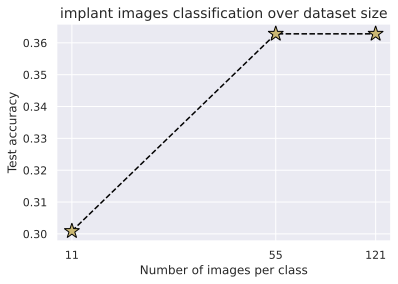

Test accuracy for  11 images per label: 30.09%
Test accuracy for  55 images per label: 36.28%
Test accuracy for 121 images per label: 36.28%


In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("implant images classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

As one would expect, the classification performance improves the more data we have. However, with only 5 images per class, we can already classify more than 35% of the images correctly. but the model performance degrade as number of images increase per class


## Baseline

In [ ]:
class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(
            pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.7), 
                                                                  int(self.hparams.max_epochs*0.9)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [ ]:
# train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
#                                        transforms.RandomGrayscale(p=0.2),
#                                        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.5,), (0.5,))
#                                        ])

# train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
#                            transform=train_transforms)

In [ ]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1,
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None
    
    # Data loaders test_data
    train_loader = data.DataLoader(train_img_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, test_dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}
        
    return model, result

In [ ]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=7,
                                           lr=1e-2,
                                           weight_decay=2e-3,
                                           max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Found pretrained model at ../saved_models/tutorial17/ResNet.ckpt, loading...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ../saved_models/tutorial17/ResNet/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Accuracy on training set: 11.81%
Accuracy on test set: 4.42%


# FastAi

## SimCLR

In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

     |████████████████████████████████| 41 kB 276 kB/s 
     |████████████████████████████████| 189 kB 7.1 MB/s 
     |████████████████████████████████| 431 kB 39.9 MB/s 
     |████████████████████████████████| 474 kB 44.9 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 


In [ ]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
WANDB = False
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

In [ ]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.simclr import *

In [ ]:
bs, resize, size = 64, 256, 224
files = get_image_files('/content/drive/MyDrive/new_data/train')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
dls

In [ ]:
arch = "xresnet50"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [ ]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

In [ ]:
model = create_simclr_model(encoder)

In [ ]:
aug_pipelines = get_simclr_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [ ]:
cbs=[SimCLR(aug_pipelines)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [ ]:
learn = Learner(dls, model, cbs=cbs)

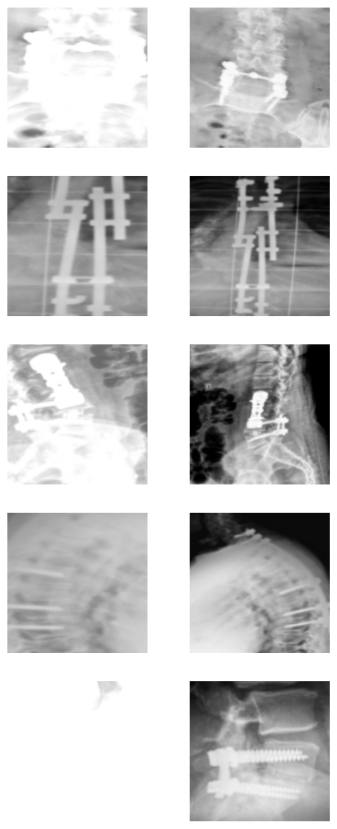

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5);

In [ ]:
learn.to_fp16();

In [ ]:
lr,wd,epochs=1e-2,1e-2,50

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


4501

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  112919 KB |    8857 MB |   24455 GB |   24455 GB |\n|       from large pool |  112896 KB |    8769 MB |   24391 GB |   24391 GB |\n|       from small pool |      23 KB |     334 MB |      63 GB |      63 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  112919 KB |    8857 MB |   24455 GB |   24455 GB |\n|       from large pool |  112896 KB |    8769 MB |

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,4.952701,4.508110,00:18
1,4.872043,4.510700,00:18
2,4.827890,4.539700,00:18
3,4.773160,nan,00:18
4,4.767499,4.412619,00:18
5,4.746475,4.463697,00:18
6,4.733262,4.318190,00:18
7,4.723813,4.334558,00:18
8,4.692278,4.226159,00:18
9,4.709312,4.444527,00:18


In [ ]:
if WANDB: wandb.finish()

In [ ]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()

### Downstream Task

In [ ]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs, size

In [ ]:
files = get_image_files('/content/drive/MyDrive/new_data/test')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet50', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    # dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [ ]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

4684

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet50', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

TypeError: ignored

In [ ]:
np.mean(acc)

0.1818181872367859

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

12976

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet50', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.040023,1.913576,0.090909,0.636364,00:02
1,1.921928,1.907750,0.090909,0.636364,00:03
2,1.832440,1.869585,0.090909,0.636364,00:03
3,1.808449,1.829422,0.090909,0.909091,00:03
4,1.768261,1.800650,0.090909,0.909091,00:02
5,1.734961,1.854658,0.090909,0.909091,00:02
6,1.696971,1.906605,0.090909,0.909091,00:02
7,1.670998,2.171882,0.090909,0.909091,00:02
8,1.643828,2.321514,0.090909,0.909091,00:02
9,1.614954,2.336234,0.090909,0.909091,00:02


In [ ]:
np.mean(acc)

0.5454545617103577

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

4469

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet50',encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.209277,1.837592,0.181818,0.818182,00:02
1,2.018270,1.827309,0.090909,1.000000,00:02
2,1.930163,1.809557,0.090909,1.000000,00:02
3,1.875025,1.774160,0.090909,1.000000,00:02
4,1.850655,1.734010,0.181818,1.000000,00:03
5,1.792577,1.689184,0.454545,1.000000,00:03
6,1.743588,1.718503,0.272727,1.000000,00:02
7,1.715434,1.796003,0.090909,1.000000,00:02
8,1.674332,1.830892,0.090909,0.909091,00:02
9,1.644621,1.900083,0.090909,0.909091,00:02


KeyboardInterrupt: ignored

In [ ]:
np.mean(acc)

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet50', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

## MoCo ImageWang

In [ ]:
bs, resize, size = 256, 256, 224

files = get_image_files('/content/drive/MyDrive/new_data/train')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [ ]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"MOCO"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Set queue size, it needs to be a multiple of batch size but needs to be less than total dataset size.

In [ ]:
#export
class MoCoModel(Module):
    # TODO: Add queue as buffer to torch module, is it needed for distrib??
    "MoCo model"
    def __init__(self,encoder,projector): 
        self.encoder,self.projector = encoder,projector
    
    def forward(self,x): 
        return F.normalize(self.projector(self.encoder(x)), dim=1)

In [ ]:
#export
def create_moco_model(encoder, hidden_size=256, projection_size=128, bn=False, nlayers=2):
    "Create MoCo model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return MoCoModel(encoder, projector)

In [ ]:
model = create_moco_model(encoder)

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_moco_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
aug_pipelines = get_moco_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [ ]:
#export
from copy import deepcopy

class MOCO(Callback):
    order,run_valid = 9,True
    def __init__(self,  aug_pipelines, K,  m=0.999, temp=0.07, print_augs=False):        
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('K,m,temp')

            
    def before_fit(self):
        "Create key encoder and init queue"
        if (not hasattr(self, "encoder_k")) and (not hasattr(self, "queue")):
            # init key encoder
            self.encoder_k = deepcopy(self.learn.model).to(self.dls.device)  
            for param_k in self.encoder_k.parameters(): param_k.requires_grad = False 
            # init queue
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
        else:warnings.warn("Key encoder and queue are already defined, keeping them.")

        self.learn.loss_func = self.lf
        
    def before_train(self):    self.encoder_k.train()
    def before_validate(self): self.encoder_k.eval()
    def before_batch(self):
        "Generate query and key for the current batch"
        q_img,k_img = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (q_img,)
        with torch.no_grad(): self.learn.yb = (self.encoder_k(k_img),)

    
    def lf(self, pred, *yb):
        q,k = pred,yb[0]
        logits = q @ torch.cat([k, self.queue]).T / self.temp # Nx(N+K) instead of original Nx(1+K)
        labels = torch.arange(len(q)).to(self.dls.device)
        return F.cross_entropy(logits, labels)
            

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

            
    @torch.no_grad()
    def _dequeue_and_enqueue(self):
        bs = self.x.size(0)
        k = self.y
        assert self.K % bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+bs, :] = k
        self.queue_ptr = (self.queue_ptr + bs) % self.K  # move pointer

    
    def after_step(self):
        "Update momentum (key) encoder and queue"
        self._momentum_update_key_encoder()
        self._dequeue_and_enqueue()
          
            
    @torch.no_grad()
    def show(self, n=1):
        x1,x2  = self.aug1(self.x), self.aug2(self.x.clone())
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), ncols=None, nrows=n)

In [ ]:
cbs=[MOCO(aug_pipelines, K=K)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [ ]:
learn = Learner(dls, model, cbs=cbs)

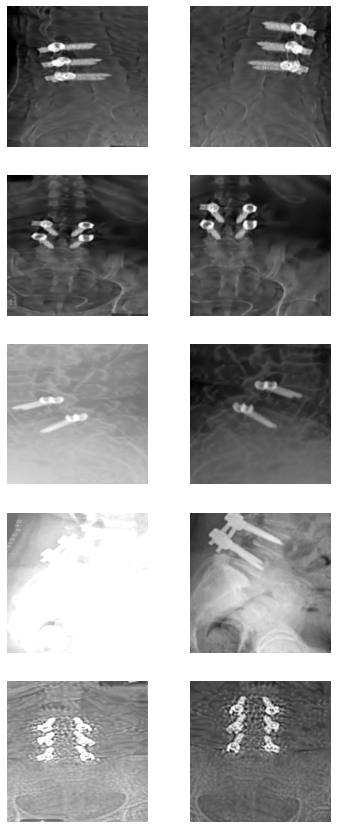

In [ ]:
b = dls.one_batch()
learn._split(b)
learn.moco.show(n=5);

*Use* mixed precision with `to_fp16()` for more GPU memory, larger batch size and faster training . We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [ ]:
learn.to_fp16();

In [ ]:
lr,wd,epochs=1e-2,1e-2,100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.071428,6.690773,04:14
1,6.984625,8.428350,00:14
2,6.997218,nan,00:14
3,6.995506,9.231031,00:14
4,7.005599,9.274141,00:14
5,6.964970,9.600436,00:14
6,6.915894,7.643370,00:14
7,6.879955,7.948480,00:14
8,6.840000,8.313345,00:14
9,6.813712,9.012352,00:14


epoch,train_loss,valid_loss,time
0,7.071428,6.690773,04:14
1,6.984625,8.428350,00:14
2,6.997218,nan,00:14
3,6.995506,9.231031,00:14
4,7.005599,9.274141,00:14
5,6.964970,9.600436,00:14
6,6.915894,7.643370,00:14
7,6.879955,7.948480,00:14
8,6.840000,8.313345,00:14
9,6.813712,9.012352,00:14


In [ ]:
if WANDB: wandb.finish()

In [ ]:
save_name = f'moco_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

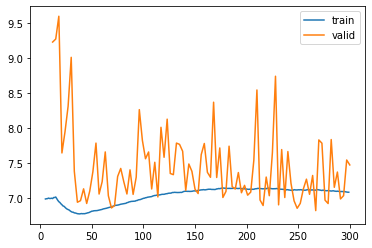

In [ ]:
learn.recorder.plot_loss()

### Downstream Task

In [ ]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs, resize, size = 128, 256, 224

files = get_image_files('/content/drive/MyDrive/new_data/test')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet50', encoder_path="models/moco_iwang_sz128_epc100_encoder.pth"):
    
    # dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [ ]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


263

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 8            |        cudaMalloc retries: 10        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1002 MB |   10604 MB |   59607 GB |   59606 GB |\n|       from large pool |     937 MB |   10545 MB |   59497 GB |   59496 GB |\n|       from small pool |      65 MB |     154 MB |     109 GB |     109 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1002 MB |   10604 MB |   59607 GB |   59606 GB |\n|       from large pool |     937 MB |   10545 MB |

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/moco_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.203595,1.916044,0.307692,0.692308,00:53
1,1.966645,1.994291,0.307692,0.846154,00:02
2,1.837634,1.942105,0.307692,0.923077,00:02
3,1.752362,1.952652,0.230769,0.923077,00:02
4,1.675630,1.871106,0.307692,0.923077,00:02


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.231962,1.854941,0.153846,0.923077,00:02
1,2.072543,2.429754,0.307692,0.769231,00:02
2,1.929223,2.230737,0.384615,0.769231,00:02
3,1.821361,1.920855,0.307692,0.923077,00:02
4,1.718987,1.850476,0.538462,0.769231,00:02


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.116320,1.872197,0.307692,0.846154,00:02
1,1.912855,2.116705,0.307692,0.846154,00:02
2,1.851073,2.144692,0.307692,0.923077,00:02
3,1.784631,2.162737,0.307692,0.846154,00:02
4,1.725295,1.991673,0.153846,0.846154,00:02


In [ ]:
np.mean(acc)

0.3333333482344945

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


11960

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/moco_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.196388,1.858744,0.307692,0.769231,00:02
1,2.005701,2.293828,0.307692,0.846154,00:02
2,1.908136,2.145870,0.307692,0.846154,00:02
3,1.829567,2.170860,0.230769,0.923077,00:02
4,1.749566,1.931317,0.307692,0.923077,00:02
5,1.664153,1.912848,0.307692,0.769231,00:02
6,1.592425,1.983755,0.384615,0.769231,00:02
7,1.528614,2.100902,0.384615,0.769231,00:02
8,1.491501,2.063775,0.538462,0.769231,00:02
9,1.452383,1.827137,0.230769,0.923077,00:02


In [ ]:
np.mean(acc)

0.46153849363327026

## SWVA

In [ ]:
bs, resize, size = 32, 256, 224
files = get_image_files('/content/drive/MyDrive/new_data/train')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
arch = "xresnet50"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [ ]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

In [ ]:
#export
class SwAVModel(Module):
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(encoder, hidden_size=256, projection_size=128, n_protos=3000, bn=True, nlayers=2):
    "Create SwAV model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [ ]:
model = create_swav_model(encoder)

In [ ]:
#export
@delegates(get_multi_aug_pipelines, but=['n', 'size', 'resize_scale'])
def get_swav_aug_pipelines(num_crops=(2,6), crop_sizes=(224,96), min_scales=(0.25,0.05), max_scales=(1.,0.14), **kwargs): 
    aug_pipelines = []
    for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
        aug_pipelines += get_multi_aug_pipelines(n=nc, size=size, resize_scale=(mins,maxs), **kwargs)
    return aug_pipelines

In [ ]:
#export
class SWAV(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, crop_assgn_ids,
                       K=3000, queue_start_pct=0.25, temp=0.1,
                       eps=0.05,  n_sinkh_iter=3, print_augs=False):
        
        store_attr('K,queue_start_pct,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = aug_pipelines
        if print_augs: 
            for aug in self.augs: print(aug)
    
    
    def before_fit(self):
        self.learn.loss_func = self.lf
        
        # init queue
        if self.K is not None:
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
            
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)


    def after_batch(self):
        with torch.no_grad():
            w = self.learn.model.prototypes.weight.data.clone()
            self.learn.model.prototypes.weight.data.copy_(F.normalize(w))
            
    
    @torch.no_grad()
    def sinkhorn_knopp(self, Q, nmb_iters, device=default_device):
        "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = (torch.ones(Q.shape[0]) / Q.shape[0]).to(device)
        c = (torch.ones(Q.shape[1]) / Q.shape[1]).to(device)

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

    
    @torch.no_grad()
    def _dequeue_and_enqueue(self, embedding):
        assert self.K % self.bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+self.bs, :] = embedding
        self.queue_ptr = (self.queue_ptr + self.bs) % self.K  # move pointer
        

    @torch.no_grad()
    def _compute_codes(self, output):
        qs = []
        for i in self.crop_assgn_ids:            
            # use queue
            if (self.K is not None) and (self.learn.pct_train > self.queue_start_pct):
                target_b = output[self.bs*i:self.bs*(i+1)]
                queue_b = self.learn.model.prototypes(self.queue)
                merged_b = torch.cat([target_b, queue_b])
                q = torch.exp(merged_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q[:self.bs])
            
            # don't use queue
            else:
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q)
        return qs
        
                
    def after_pred(self):
        "Compute ps and qs"
        
        embedding, output = self.pred
        
        # Update - no need to store all assignment crops, e.g. just 0 from [0,1]
        # Update queue only during training
        if (self.K is not None) and (self.learn.training):  self._dequeue_and_enqueue(embedding[:self.bs])
            
        # Compute codes
        qs = self._compute_codes(output)
        
        # Compute predictions
        log_ps = []
        for v in np.arange(len(self.augs)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
        
        log_ps, qs = torch.stack(log_ps), torch.stack(qs)
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
        
    def lf(self, pred, *yb):
        log_ps, qs, loss = pred, yb[0], 0
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss -= (ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss
        
    @torch.no_grad()
    def show(self, n=1):
        xbs = self.learn.xb[0]
        idxs = np.random.choice(range(self.bs), n, False)
        images = [aug.decode(xb.to('cpu').clone()).clamp(0, 1)[i] 
                  for i in idxs
                  for xb, aug in zip(xbs, self.augs)]
        return show_batch(images[0], None, images, max_n=len(images), nrows=n)

In [ ]:
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [ ]:
K=bs

In [ ]:
cbs=[SWAV(aug_pipelines, crop_assgn_ids=[0,1], K=K, queue_start_pct=0.5, temp=0.1)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [ ]:
learn = Learner(dls, model, cbs=cbs)

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


520

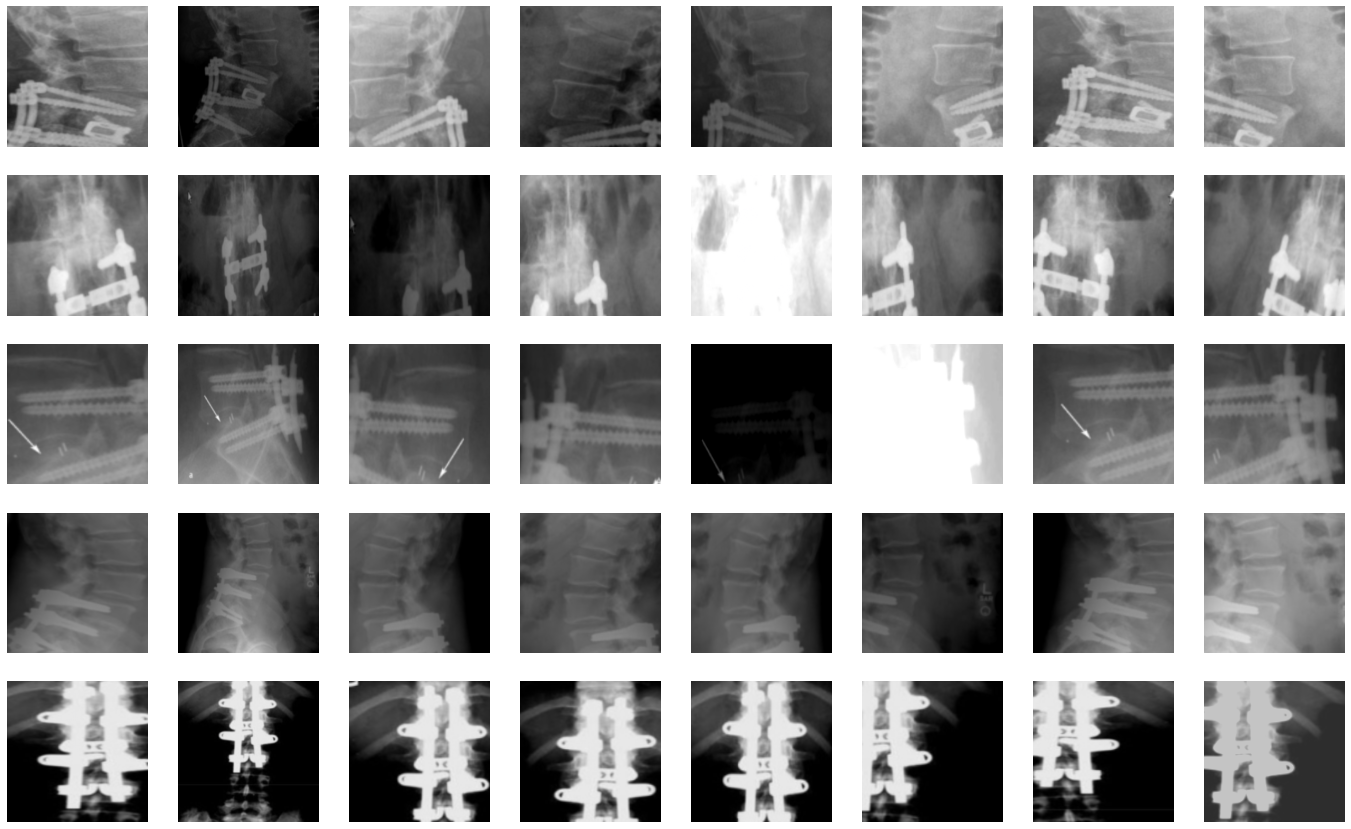

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);

In [ ]:
learn.to_fp16();

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
lr,wd,epochs=1e-2,1e-2,100

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


80191

## boyl

In [ ]:
bs, resize, size = 64, 256, 224
files = get_image_files('/content/drive/MyDrive/new_data/train')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)

In [ ]:
bs, resize, size = 256, 256, 224

In [ ]:
arch = "xresnet50"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [ ]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"BYOL"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

In [ ]:
#export
class BYOLModel(Module):
    "Compute predictions of v1 and v2" 
    def __init__(self,encoder,projector,predictor):
        self.encoder,self.projector,self.predictor = encoder,projector,predictor    

    def forward(self,v1,v2):
        "Symmetric predictions for symmetric loss calc"
        q1 = self.predictor(self.projector(self.encoder(v1)))
        q2 = self.predictor(self.projector(self.encoder(v2)))
        return (q1,q2)

In [ ]:
#export
def create_byol_model(encoder, hidden_size=4096, projection_size=256, bn=True, nlayers=2):
    "Create BYOL model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    predictor = create_mlp_module(projection_size, hidden_size, projection_size, bn=bn, nlayers=nlayers)
    apply_init(projector)
    apply_init(predictor)
    return BYOLModel(encoder, projector, predictor)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_byol_model(encoder, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224)), torch.randn((2,3,224,224)))
out[0].shape, out[1].shape

(torch.Size([2, 128]), torch.Size([2, 128]))

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_byol_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
aug_pipelines = get_byol_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [ ]:
#export
from copy import deepcopy

class BYOL(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, m=0.999, print_augs=False):        
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr("m")

    def before_fit(self):
        "Create target model"
        self.target_model = deepcopy(self.learn.model).to(self.dls.device)
        for param_k in self.target_model.parameters(): param_k.requires_grad = False 
        self.learn.loss_func = self.lf
    
    def before_train(self):    self.target_model.train()
    def before_validate(self): self.target_model.eval()
    def before_batch(self):
        "Generate 2 views of the same image and calculate target projections for these views"
        v1,v2 = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (v1,v2)
    
        with torch.no_grad():
            z1 = self.target_model.projector(self.target_model.encoder(v1))
            z2 = self.target_model.projector(self.target_model.encoder(v2))
            self.learn.yb = (z1,z2)

            
    def _mse_loss(self, x, y):
        x,y = F.normalize(x), F.normalize(y)
        return 2 - 2 * (x * y).sum(dim=-1)

    
    def lf(self, pred, *yb):
        (q1,q2),(z1,z2) = pred,yb
        return (self._mse_loss(q1,z2) + self._mse_loss(q2,z1)).mean()
        
 
    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.target_model.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)
            

    def after_step(self):
        "Momentum update target model"
        self._momentum_update_target_encoder()

        
    @torch.no_grad()
    def show(self, n=1):
        x1,x2  = self.learn.xb
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), ncols=None, nrows=n)

In [ ]:
cbs=[BYOL(aug_pipelines)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [ ]:
learn = Learner(dls, model, cbs=cbs)

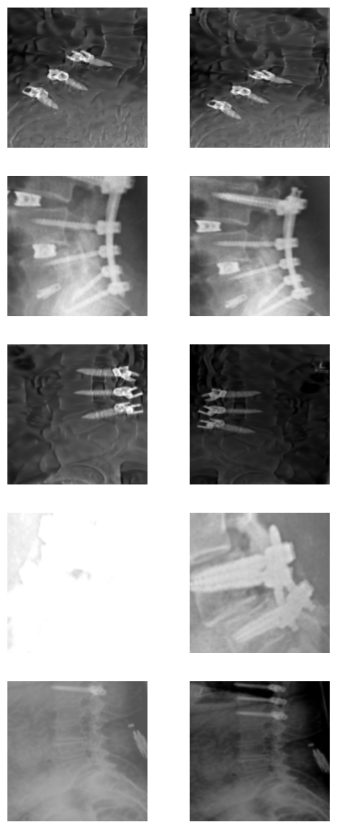

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')
learn.byol.show(n=5);

In [ ]:
learn.to_fp16();

In [ ]:
lr,wd,epochs=1e-2,1e-2,100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,2.080966,0.636951,00:40
1,1.664230,1.975564,00:35
2,1.539361,1.630300,00:35
3,1.391837,1.412634,00:35
4,1.255453,1.393168,00:35
5,1.135766,1.285475,00:35
6,1.006803,0.755372,00:35
7,0.898696,0.549871,00:35
8,0.799881,0.778168,00:35
9,0.713538,0.381340,00:35


In [ ]:
if WANDB: wandb.finish()

In [ ]:
save_name = f'byol_iwang_'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

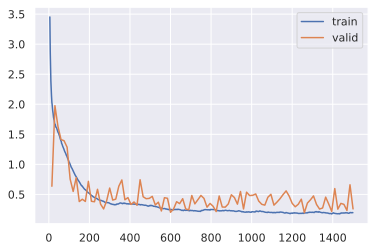

In [ ]:
learn.recorder.plot_loss()

In [ ]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs, size

(64, 224)

In [ ]:
bs, resize, size = 64, 256, 224
files = get_image_files('/content/drive/MyDrive/new_data/test')
tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
batch_tfms = [IntToFloatTensor]
dls = dsets.dataloaders(bs=bs, num_workers=None, after_batch=batch_tfms)